In [52]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import igraph
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.patches as patches
import scanpy as sc
import os
import re
import pickle
from matplotlib_venn import venn2

I'll be following the scvelo vignette for performing RNA velocity analysis BEYOND creating stream plots. Those are all contained in the velocity_analysis.qmd markdown.

I'm performing this analysis for just the objects that contain cancer cells.

In [2]:
sc_obs = ['mm_mets_cancer_cells', 'patient_mets_cancer_cells', 'mm_prim_cancer_cells', 'patient_prim_cancer_cells', 'dogs_prim_cancer_cells', 'dogs_mets_cancer_cells']
sn_obs = ['mm_mets_cancer_cells', 'patient_mets_cancer_cells', 'dogs_mets_cancer_cells', 'patient_prim_cancer_cells']
# os.makedirs("loom_output/split_ad/sc")
# os.makedirs("loom_output/split_ad/sn")
# os.makedirs("figures/scvelo/split_methods/sc")
# os.makedirs("figures/scvelo/split_methods/sn")


# Get Velocity Driving Genes

First, I'm going to get the top 100 genes in terms of "velocity score" within each Ann_Level3.

## Single-Nucleus

In [3]:
sn_velo_genes = dict()
sn_ob_dict = dict()
# get velocity-driving genes
for ob in sn_obs:
    tmp = anndata.read("loom_output/split_ad/sn/" + ob + ".ad")
    sn_ob_dict[ob] = tmp
    scv.tl.rank_velocity_genes(tmp, groupby = "Ann_Level3", min_corr = 0.3)
    rank_genes = tmp.uns["rank_velocity_genes"]
    df = pd.DataFrame(tmp.uns["rank_velocity_genes"]["names"])
    sn_velo_genes[ob] = df


ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:25) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


## Single Cell

In [4]:
sc_velo_genes = dict()
sc_ob_dict = dict()
# get velocity-driving genes
for ob in sc_obs:
    tmp = anndata.read("loom_output/split_ad/sc/" + ob + ".ad")
    sc_ob_dict[ob] = tmp
    scv.tl.rank_velocity_genes(tmp, groupby = "Ann_Level3", min_corr = 0.3)
    rank_genes = tmp.uns["rank_velocity_genes"]
    df = pd.DataFrame(tmp.uns["rank_velocity_genes"]["names"])
    sc_velo_genes[ob] = df

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:04) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:14) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:17) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:09) --> added 
   

# Compare Velocity Driving Genes

Now I'm going to investigate what genes are driving the velocity results.

## Shared Genes Across Methods and Tumor type

Since we have both single-cell and single-nuclei data, and since scvelo was built around single-cell data, I'm going to assess how consistent the results are across methods. I expect to see a significant amount of differences between the two. If this is the case, I'm going to ditch the single-nuclei data and only analyze the single-cell data.

### Tumor Apoptosis

In [ ]:
sc_obs = list(sc_velo_genes.keys())
sn_obs = list(sn_velo_genes.keys())

like_keys = set(sc_obs) & set(sn_obs)
like_keys

num_venns = len(like_keys)
# #set subplot layout
# cols = 3
# rows = 1
# fig, axes = plt.subplots(rows, cols, figsize = (cols * 6, rows * 5))

def velo_venn(cell_type):
    #set subplot layout
    cols = 3
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 6, rows * 5))
    for i, ob in enumerate(like_keys):
        # just get genes from tumor apoptosis; they're all the same across the tumor types
        sn_genes = sn_velo_genes[ob][cell_type]
        sc_genes = sc_velo_genes[ob][cell_type]
        ax = axes[i]
        venn2([set(sn_genes), set(sc_genes)], set_labels = ("Single Nuclei", "Single Cell"), ax = ax)
        ax.set_title(f"Velocity-Driving Genes in {ob}")
    plt.tight_layout()
    plt.show()

velo_venn("Tumor_Apoptosis")


### Tumor Fibrogenic

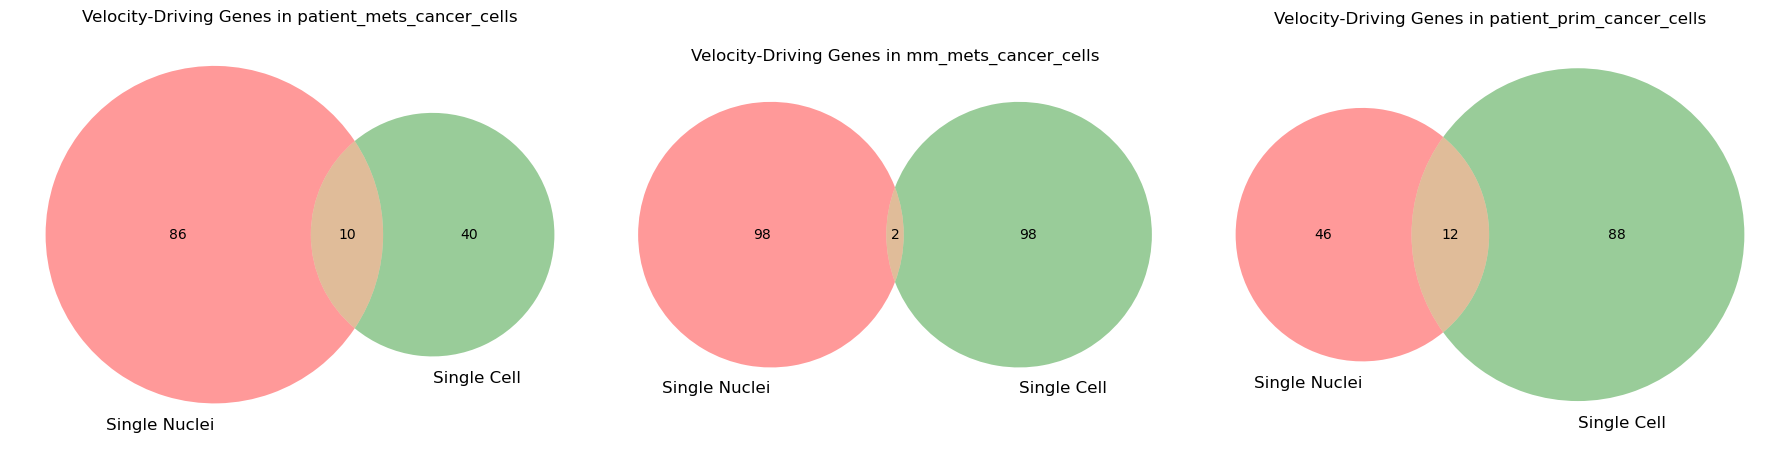

In [53]:
velo_venn("Tumor_Fibrogenic")

### Tumor Interactive

In [24]:
velo_venn("Tumor_Interactive")

NameError: name 'velo_venn' is not defined

### Tumor Progenitor

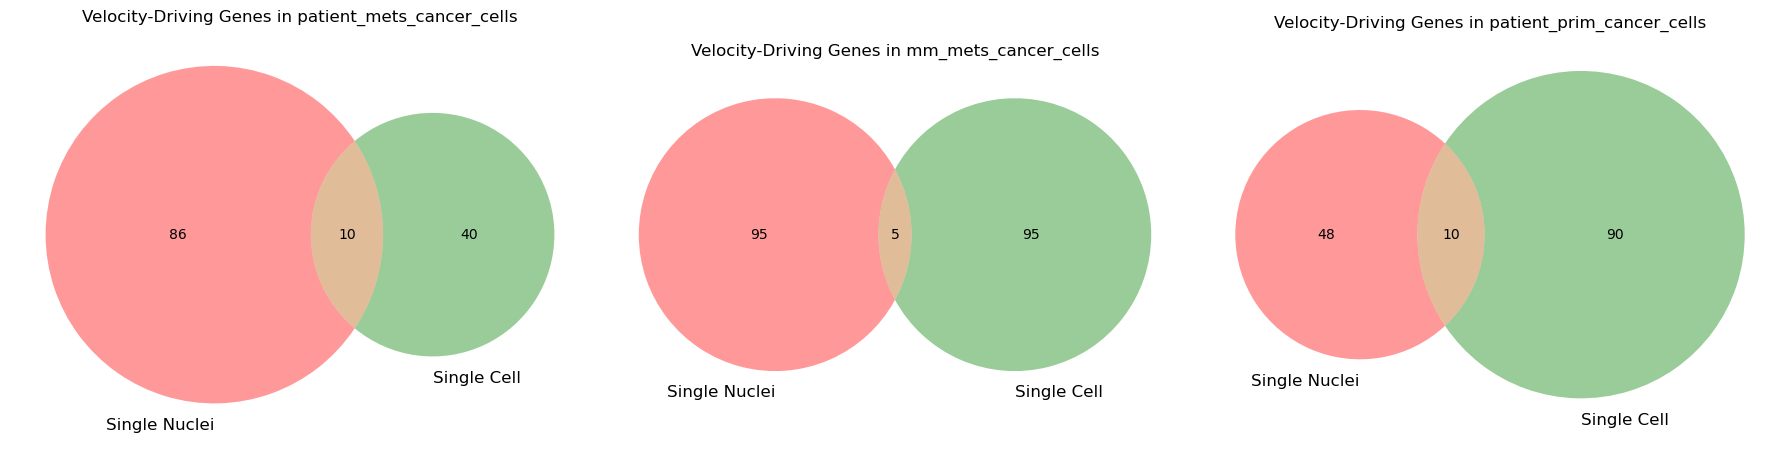

In [55]:
velo_venn("Tumor_Progenitor")

### Tumor Proliferative

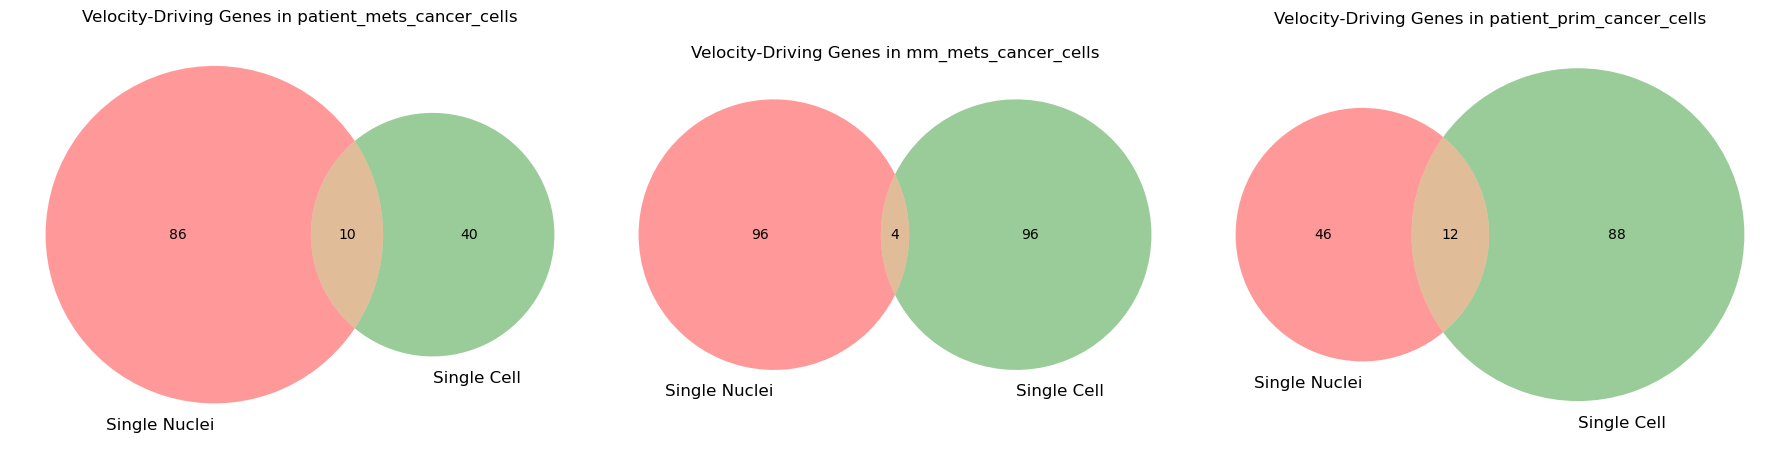

In [56]:
velo_venn("Tumor_Proliferative")

### Tumor Synthetic

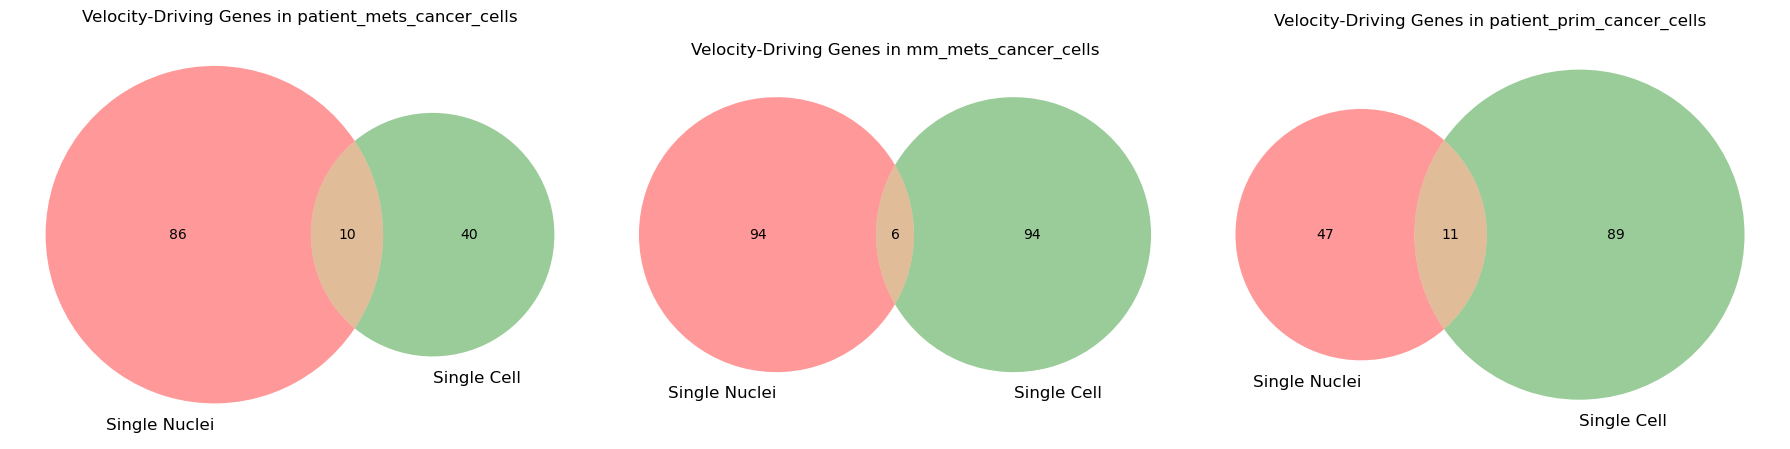

In [57]:
velo_venn("Tumor_Synthetic")

It doesn't seem like there's many shared RNA velocity driver genes between the two technologies. I'm not at all surprised by this.

## Examine Velocity In Shared Genes

For a subset of the genes that are shared between the two sequencing methods, I'm going to look at the velocity values for each technology in the same umap space.

I'll look at this in patient primary cancer cells, as these samples shared the most velocity-driving genes across all cell types.

In [24]:
sc_patient_prim = sc_ob_dict["patient_prim_cancer_cells"]
sn_patient_prim = sn_ob_dict["patient_prim_cancer_cells"]

# get shared top velocity genes
sc_pp_genes = set(sc_velo_genes["patient_prim_cancer_cells"].values.flatten().tolist())
sn_pp_genes = set(sn_velo_genes["patient_prim_cancer_cells"].values.flatten().tolist())

shared_pp_genes = list(sc_pp_genes & sn_pp_genes)

# also get top genes for each cell type in each technology
top_sc = sc_velo_genes["patient_prim_cancer_cells"].iloc[0, ]
top_sn = sn_velo_genes["patient_prim_cancer_cells"].iloc[0, ]
top_sc

Tumor_Apoptosis        NDRG1
Tumor_Fibrogenic         FN1
Tumor_Interactive      HMOX1
Tumor_Progenitor       PTH1R
Tumor_Proliferative      GRP
Tumor_Synthetic        PANX3
Name: 0, dtype: object

We have 13 genes across all tumor subtyes that have cluster-specific differential velocity expression in both the single-cell and single-nuclei patient primary data.


In [ ]:
scv.pl.velocity(sc_patient_prim, shared_pp_genes[:5], color = "Ann_Level3", ncols = 2)
scv.pl.velocity(sn_patient_prim, shared_pp_genes[:5], color = "Ann_Level3", ncols = 2)

Even in just these 5 genes, it is always the case that the velocity scores are greater in the single-cell data by a factor of ~10. Thus, including the single-nuclei data in the velocity analysis will likely induce noise.

# Compare Confidence and Magnitude of Velocity Across Data types

We can get estimates of the speed of the velocity -- the length of the velocity vectors -- and the coherence of the velocity -- how much do the velocity vectors "agree" with each other within a certain cell type.

In [ ]:
# first we'll add velocity length and confidence to our anndata objects
for ob in sc_obs:
    scv.tl.velocity_confidence(sc_ob_dict[ob])

for ob in sn_obs:
    scv.tl.velocity_confidence(sn_ob_dict[ob])




    # df = tmp.obs.groupby("Ann_Level3")[keys].mean().T
    # df.style.background_gradient(cmap = "coolwarm", axis = 1)


## Patient Primary

In [53]:
# Function for making colored tables of velocity magnitude and confidence
def velo_len_conf_table(ob):
    keys = ["velocity_length", "velocity_confidence"]
    sc_df = sc_ob_dict[ob].obs.groupby("Ann_Level3")[keys].mean().T. \
        rename(index = {"velocity_length": "sc_velo_length", "velocity_confidence": "sc_velo_confidence"})
    sn_df = sn_ob_dict[ob].obs.groupby("Ann_Level3")[keys].mean().T. \
        rename(index = {"velocity_length": "sn_velo_length", "velocity_confidence": "sn_velo_confidence"})
    sn_df.reindex(index = ["sn_velo_length", "sn_velo_confidence"])
    comb_df = pd.concat([sc_df, sn_df])
    styled_out = comb_df.style.background_gradient(subset=pd.IndexSlice[["sc_velo_length", "sn_velo_length"], :], axis=None, cmap = "coolwarm") \
        .background_gradient(subset=pd.IndexSlice[["sc_velo_confidence", "sn_velo_confidence"], :], axis=None, cmap = "coolwarm")
    display(styled_out)
    # # return(comb_df)

velo_len_conf_table("patient_prim_cancer_cells")

## Patient Mets

In [57]:
velo_len_conf_table("patient_mets_cancer_cells")

## Mouse Mets

In [56]:
velo_len_conf_table("mm_mets_cancer_cells")

## Dog Mets

In [55]:
velo_len_conf_table("dogs_mets_cancer_cells")

# Stream Plots for Different Methods

I'm curious whether or not the directionality of the velocity changes significantly across methods within each of the different methods.

In [87]:
color_mapping = {"Tumor_Synthetic": "#D43F3A",
                 "Tumor_Fibrogenic": "#EEA236",
                 "Tumor_Progenitor": "#357EBD",
                 "Tumor_Proliferative": "#5CB85C",
                 "Tumor_Interactive": "#B8B8B8",
                 "Tumor_Apoptosis": "#9632B8"}



# function to produce stream embedding plots for each model and each method
def umap_panel(ob):
    # get sc ob and sn ob
    sc_ob = sc_ob_dict[ob]
    sn_ob = sn_ob_dict[ob]
    # set figure parameters
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
    # column and row titles
    row_titles = ["UMAP", "FDL"]
    col_titles = ["Single-Cell", "Single-Nuclei"]    
    for i, red in enumerate(["umap", "fdl"]):
        # get x and y bound for umap coordinates
        x_red = list(sc_ob.obsm["X_" + red][:, 0]) + list(sn_ob.obsm["X_" + red][:, 0])
        min_x = min(x_red)
        max_x = max(x_red)
        y_red = list(sc_ob.obsm["X_" + red][:, 1]) + list(sn_ob.obsm["X_" + red][:, 1])
        min_y = min(y_red)
        max_y = max(y_red)
        for j, method in enumerate([sc_ob, sn_ob]):
            ax = axes[i, j]
            scv.pl.velocity_embedding_stream(method,
                                             basis = red,
                                             ax = ax,
                                             color = "Ann_Level3",
                                             palette = color_mapping,
                                             show = False,
                                             xlim = [min_x - 0.25, max_x + 0.25],
                                             ylim = [min_y - 0.25, max_y + 0.25])
            # add titles; only do so if it's the first row
            if i == 0:
                ax.set_title(col_titles[j], fontsize=20, pad=10)
            # Add a rectangle border around each subplot
            rect = patches.Rectangle(
                (0, 0), 1, 1, transform=ax.transAxes,
                linewidth=2, edgecolor='black', facecolor='none', zorder=10
            )
            ax.add_patch(rect)
    for i, title in enumerate(row_titles):
        # y-coordinate = 0.5 of row, x = a bit left of the figure
        fig.text(0.04, 0.74 - i * 0.48, title, va='center', ha='center', rotation='vertical', fontsize=20)

    plt.tight_layout(rect=[0.08, 0, 1, 1])  # Leave space for row labels
    plt.show()
    
    plt.tight_layout()
    plt.show()





## Patient Primary

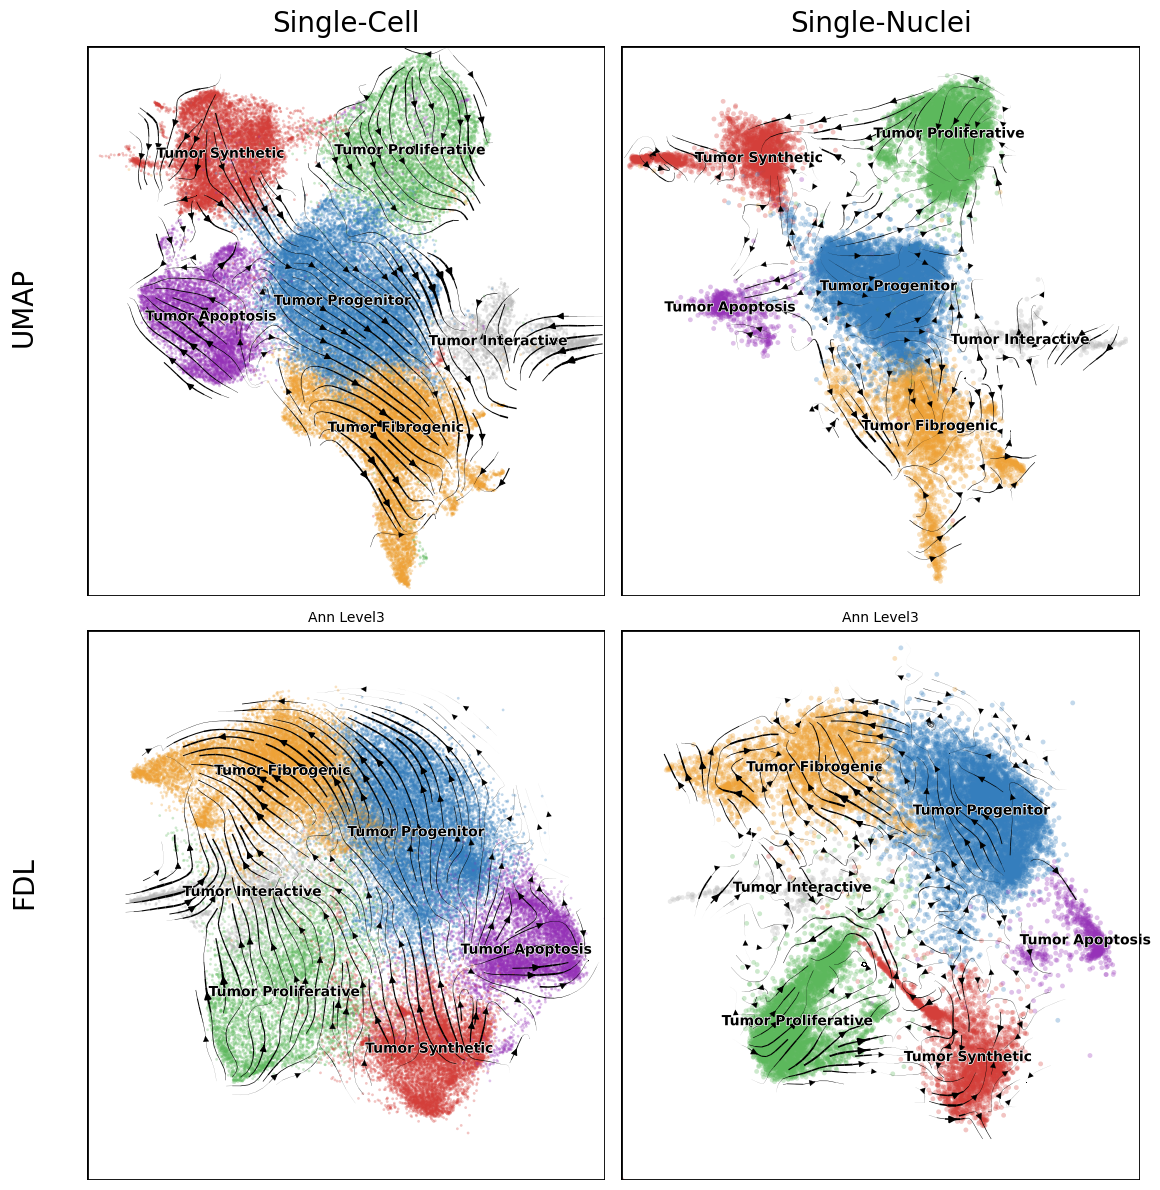

<Figure size 640x480 with 0 Axes>

In [88]:
umap_panel("patient_prim_cancer_cells")

## Patient Mets

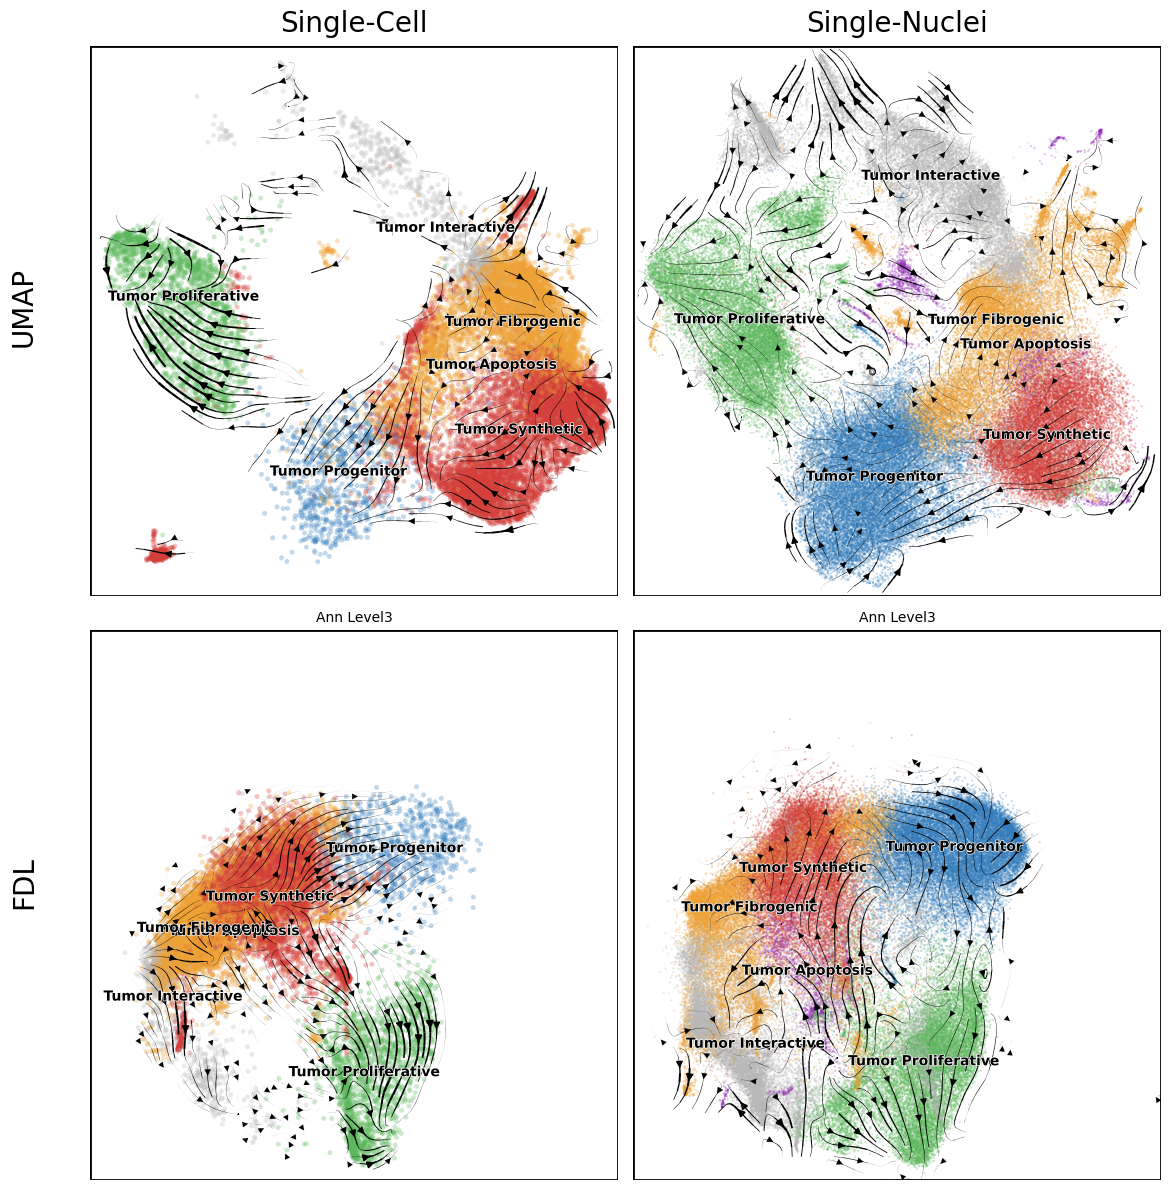

<Figure size 640x480 with 0 Axes>

In [89]:
umap_panel("patient_mets_cancer_cells")

## Mouse Mets

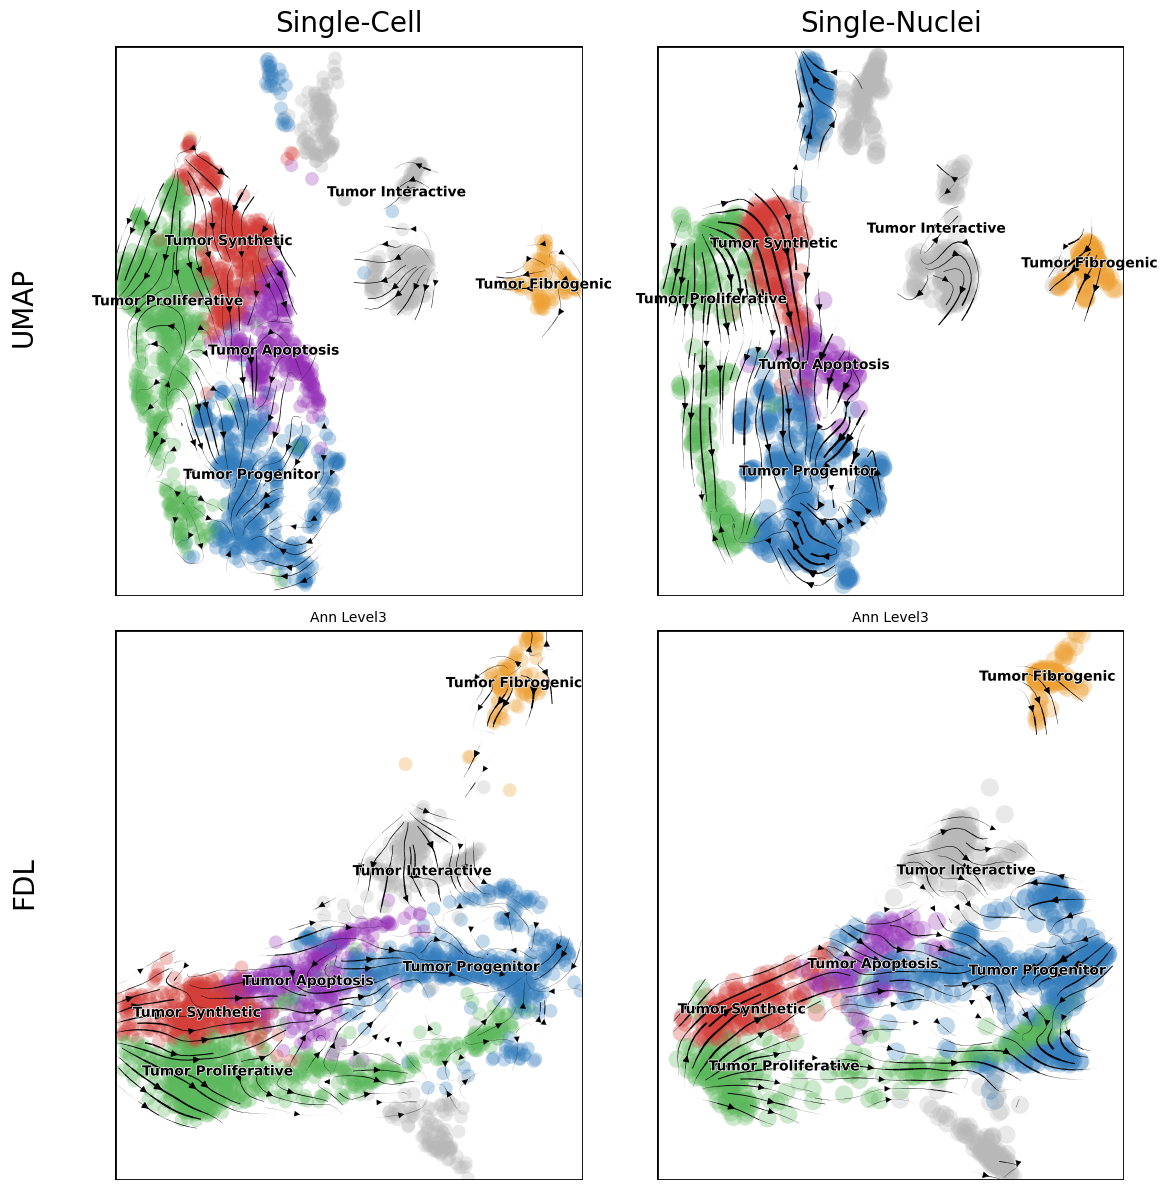

<Figure size 640x480 with 0 Axes>

In [90]:
umap_panel("mm_mets_cancer_cells")

## Dog Mets

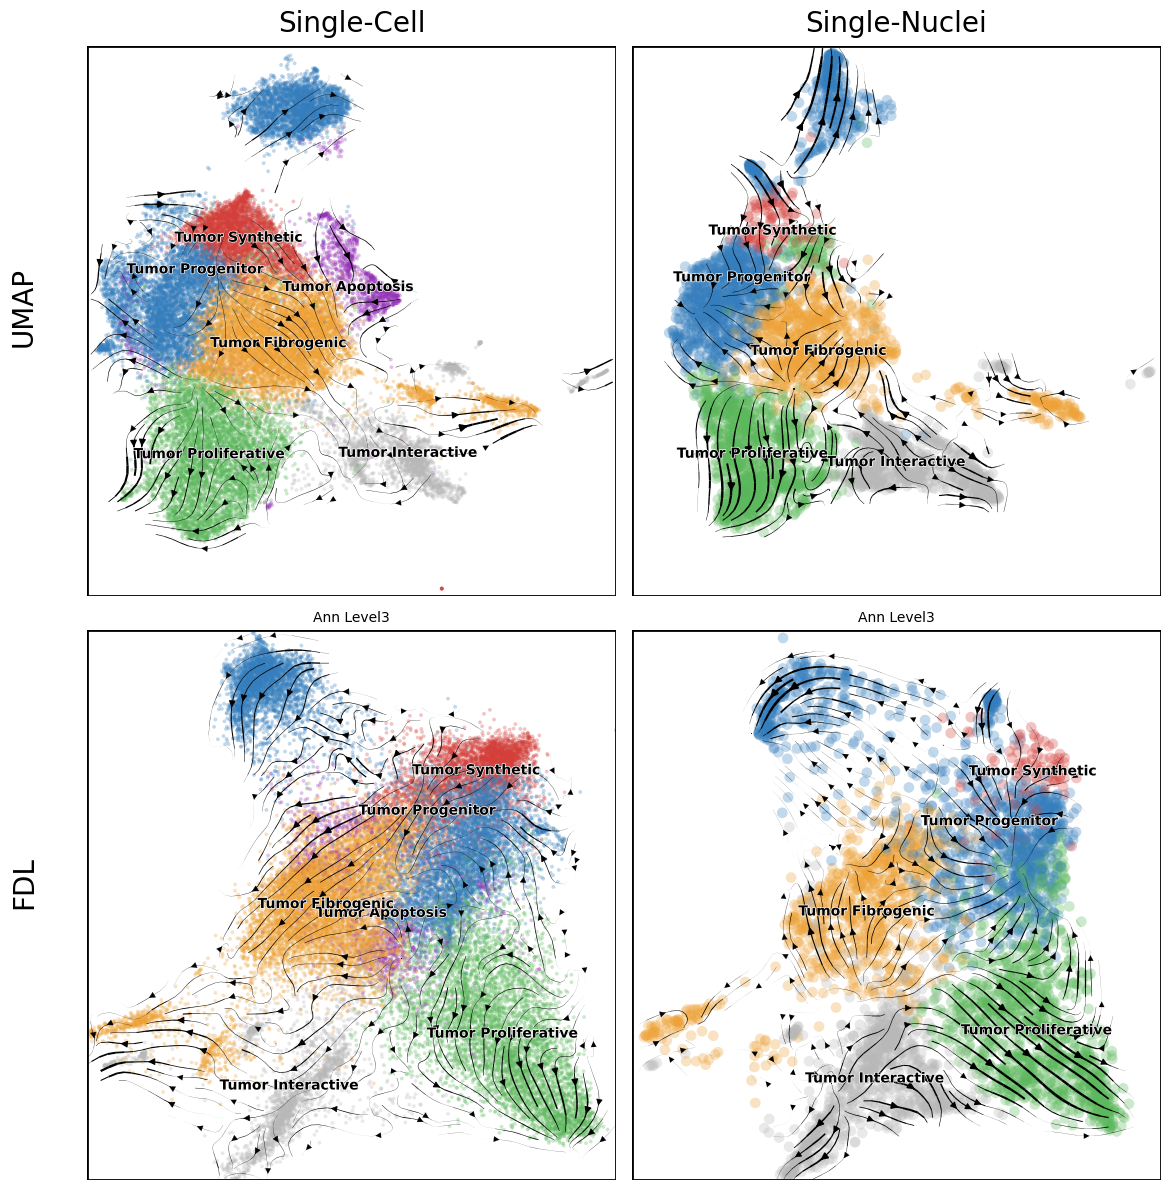

<Figure size 640x480 with 0 Axes>

In [91]:
umap_panel("dogs_mets_cancer_cells")

# Infer Trajectory with PAGA

We can infer cell trajectory from the RNA velocity using PAGA. PAGA aims to create a graph-like map based on connectivity of the manifold partitions (clusters) in single cell data that can also preserve the global topology of the data, which is lost with the standard clustering steps. This can be combined with RNA velocity information to make a more robust prediction of cell trajectory.

In [ ]:
sc_keys = list(sc_ob_dict.keys())
keys = "velocity_length", "velocity_confidence"
for ob in sc_keys:
    tmp = sc_ob_dict[ob]
    scv.tl.velocity_confidence(tmp)
    tmp.uns['neighbors']['distances'] = tmp.obsp['distances']
    tmp.uns['neighbors']['connectivities'] = tmp.obsp['connectivities']
    scv.tl.paga(tmp, groups='Ann_Level3')
    sc_ob_dict[ob] = tmp


sn_keys = list(sn_ob_dict.keys())
for ob in sn_keys:
    tmp = sn_ob_dict[ob]
    scv.tl.velocity_confidence(tmp)
    tmp.uns['neighbors']['distances'] = tmp.obsp['distances']
    tmp.uns['neighbors']['connectivities'] = tmp.obsp['connectivities']
    scv.tl.paga(tmp, groups='Ann_Level3')
    sn_ob_dict[ob] = tmp

In [146]:
def joint_paga(ob, alpha = 0.01):
    sc_ob = sc_ob_dict[ob]
    sn_ob = sn_ob_dict[ob]
    # using fdl bc i think it makes more sense if you're trying to show trajectory
    scv.pl.paga(sc_ob,
                basis = "fdl",
                alpha = alpha,
                size = 50,
                min_edge_width = 2,
                node_size_scale = 1.5,
                node_size_power = 0,
                palette = color_mapping,
                title = "Trajectory in Single-Cell Data")
    scv.pl.paga(sn_ob,
                basis = "fdl",
                alpha = alpha,
                size = 50,
                min_edge_width = 2,
                node_size_scale = 1.5,
                node_size_power = 0,
                palette = color_mapping,
                title = "Trajectory in Single-Nuclei Data")
    plt.tight_layout()
    plt.show()

## Comparing Single-Cell to Single-Nuclei

Our last assessment of the differences between the single-cell and single-nuclei derived velocity information will be comparing the inferred cell trajectories in each.

### Patient Primary

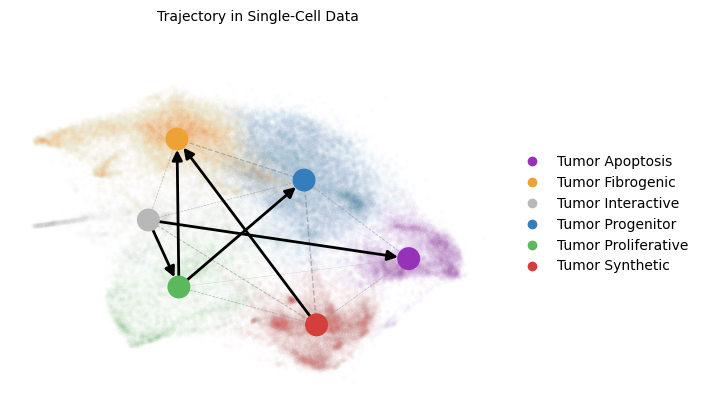

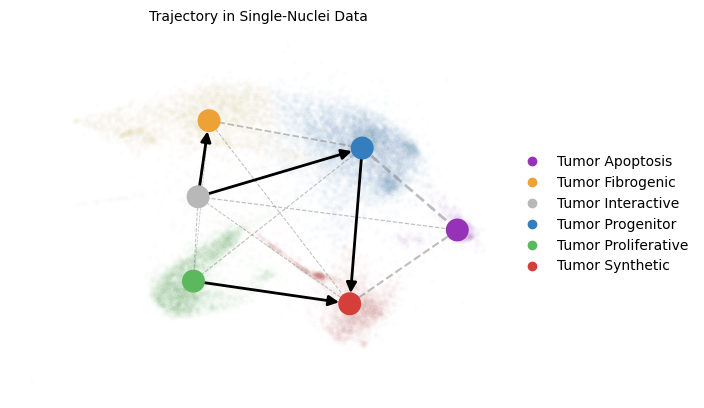

<Figure size 640x480 with 0 Axes>

In [143]:
joint_paga("patient_prim_cancer_cells")

### Patient Mets

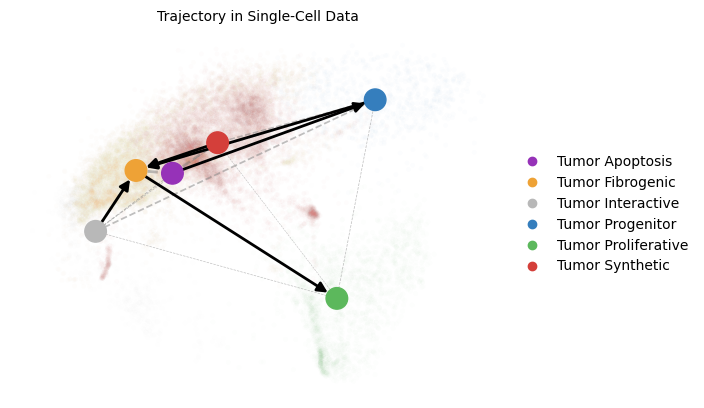

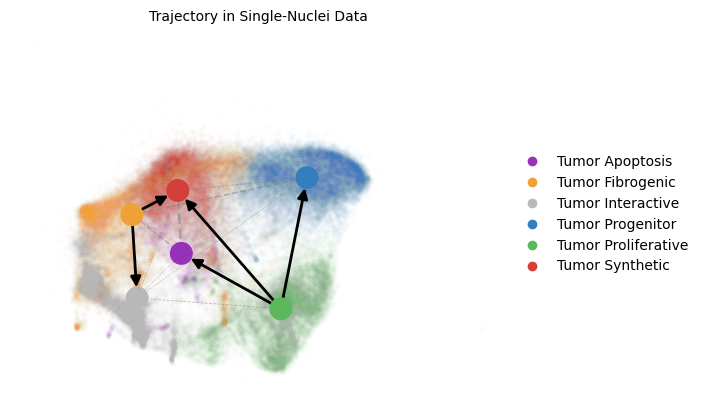

<Figure size 640x480 with 0 Axes>

In [142]:
joint_paga("patient_mets_cancer_cells")

### Mouse Mets

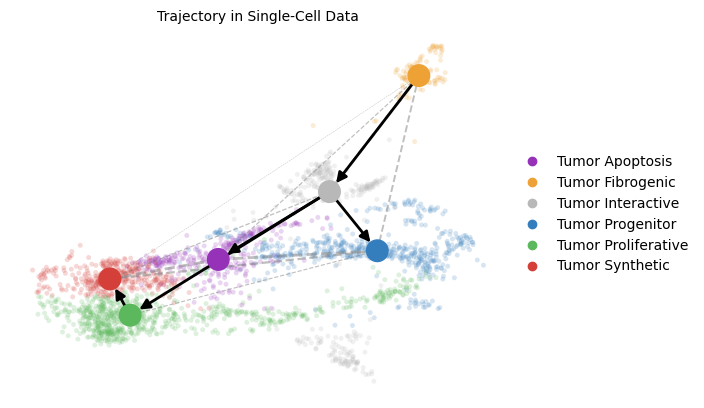

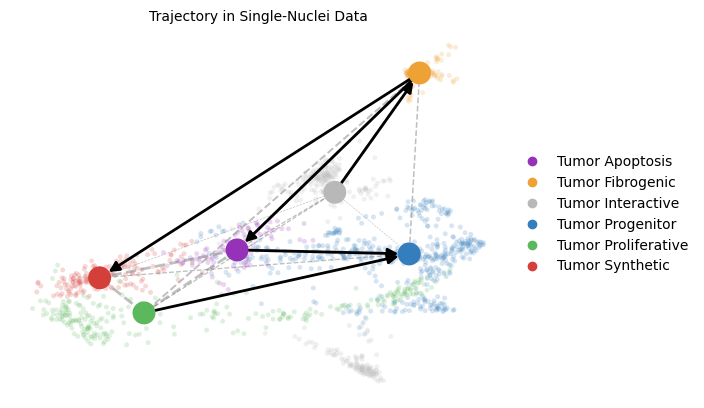

<Figure size 640x480 with 0 Axes>

In [148]:
joint_paga("mm_mets_cancer_cells", alpha = 0.2)

### Dog Mets

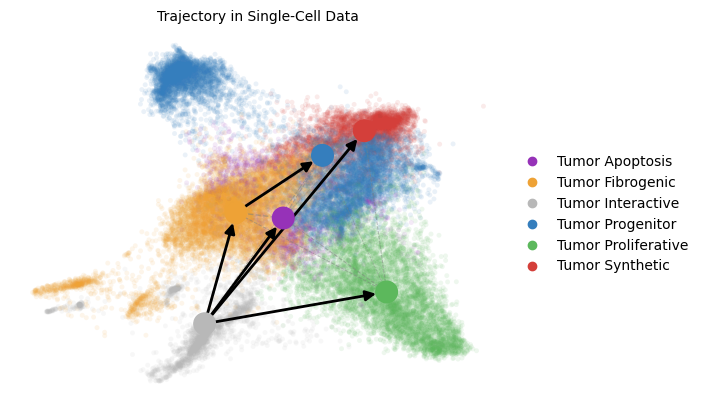

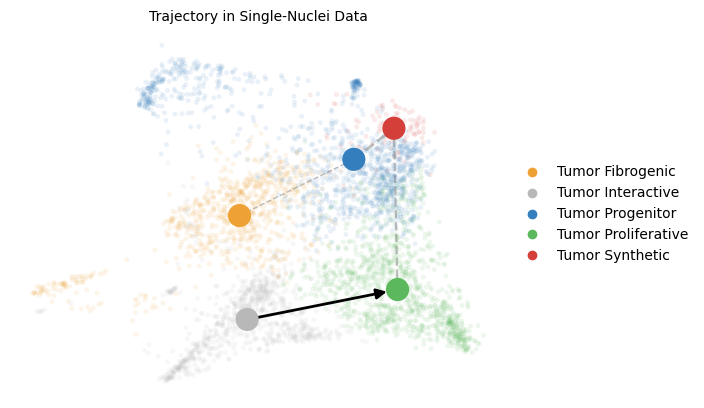

<Figure size 640x480 with 0 Axes>

In [150]:
joint_paga("dogs_mets_cancer_cells", alpha = 0.1)

## Compare Trajectory Across Models

Now that we see there are strong discrepancies between the single-nuclei- and single-cell-derived RNA velocity data, I'm going to proceed with analysis of just the single-cell data. Using the PAGA results, I'm going to compare the inferred trajectories across our models to look for any consistent patterns

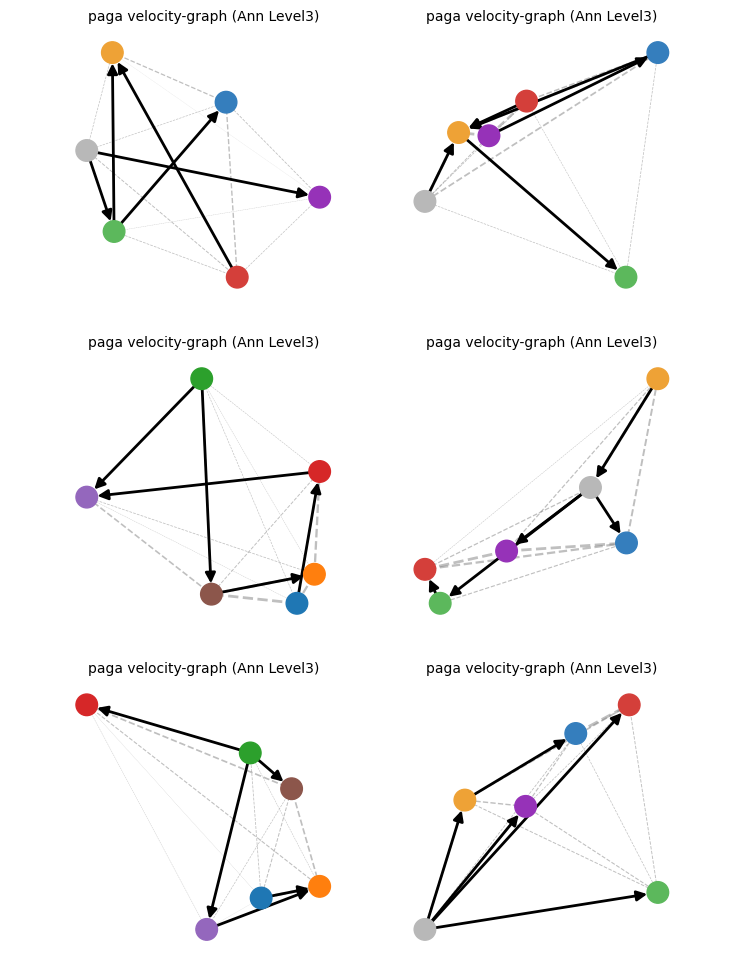

In [155]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (8, 12))
row_titles = ["Mouse", "Patient", "Dogs"]
col_titles = ["Primary", "Metastatic"]

for i, model in enumerate(["patient", "mm", "dogs"]):
    for j, stage in enumerate(["prim", "mets"]):
        ax = axes[i, j]
        if (i == 0):
            ax.set_title(stage, fontsize=20, pad=10)
        ob = sc_ob_dict[model + "_" + stage + "_cancer_cells"]
        scv.pl.paga(ob,
                    basis = "fdl",
                    size = 50,
                    alpha = 1,
                    min_edge_width = 2,
                    node_size_scale = 1.5,
                    node_size_power = 0,
                    ax = ax,
                    show = False)
plt.show()


